# Практическая часть эксперимента

In [1]:
import sys

sys.path.append("/home/alex/dev/uni/formal-lang-course/")

In [2]:
import time

import cfpq_data as cd
import pandas as pd
from scipy.sparse import (
    csc_matrix,
    csr_matrix,
    dok_matrix,
    lil_matrix,
)
from task1 import GraphInfo
from task5 import experimental_ms_bfs_based_rpq, experimental_tensor_based_rpq

import sources directory


Выбранные графы:
* `generations`
* `travel`

In [3]:
graph_names = ["generations", "travel"]

matrix_types = {
    csr_matrix: "csr",
    csc_matrix: "csc",
    dok_matrix: "dok",
    lil_matrix: "lil",
}

In [4]:
def get_counted_labels(graph) -> dict[str, int]:
    labelsNotCounted = [edge[2] for edge in list(graph.edges(data="label"))]
    labelsCounted: dict[str, int] = {}
    while len(labelsNotCounted) != 0:
        label = labelsNotCounted.pop()
        if label not in labelsCounted:
            labelsCounted[label] = 1
        else:
            labelsCounted[label] += 1

    orderedLabelsCounted = dict(
        sorted(labelsCounted.items(), key=lambda x: x[1], reverse=True)
    )

    return orderedLabelsCounted

Запросы:
* `l1* | l2*`
* `(l1 | l2)* l3`
* `(l3 | l4)+ l1*`
* `l1 l2 l3 (l4|l1)*`

In [5]:
def build_regexes(counted_labels) -> list[str]:
    orderedLabels = list(counted_labels.keys())
    l1, l2, l3, l4 = (
        orderedLabels[0],
        orderedLabels[1],
        orderedLabels[2],
        orderedLabels[3],
    )

    return [
        f"{l1}* | {l2}",
        f"({l1} | {l2})* {l3}",
        f"({l1} | {l2})+ {l3}*",
        f"{l1} {l2} {l3} ({l4} | {l1})*",
    ]


regexes = {
    graph_name: build_regexes(get_counted_labels(GraphInfo(graph_name)._graph))
    for graph_name in graph_names
}

[2024-10-16 01:31:14]>INFO>Found graph with name='generations'
[2024-10-16 01:31:15]>INFO>Load archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations.tar.gz')
[2024-10-16 01:31:15]>INFO>Unzip graph name='generations' to file graph=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations/generations.csv')
[2024-10-16 01:31:15]>INFO>Remove archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations.tar.gz')
[2024-10-16 01:31:15]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f55541af1a0> from path=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations/generations.csv')
[2024-10-16 01:31:15]>INFO>Construct labels_frequency=defaultdict(<class 'int'>, {'rest': 45, 'first': 45, 'onP

In [6]:
results = {
    "algorithm": [],
    "graph_name": [],
    "matrix_format": [],
    "regex": [],
    "start_nodes_percentage": [],
    "time": [],
}

`dok_matrix` не используется при постановке эксперимента с помощью `tensor_based_rpq`, так как для проведения эксперимента потребуется слишком большое количество времени и ресурсов, что видно из следующего блока.

In [7]:
matrix_types_test = {dok_matrix: "dok"}
time_total = 0
times = 20

for graph_name in graph_names:
    graph_test = GraphInfo(graph_name)._graph
    start_nodes_test = cd.generate_multiple_source(
        graph_test, int(0.05 * len(graph_test.nodes))
    )
    for matrix_type, matrix_format in matrix_types_test.items():
        for regex in regexes["generations"]:
            st = time.time()
            experimental_tensor_based_rpq(
                regex,
                graph_test,
                start_nodes_test,
                None,
                matrix_type,
                matrix_format,
            )
            fn = time.time()
            elapsed_time = fn - st
            time_total += fn - st
            print(
                f"tensor_based_rqp | {matrix_type.__name__} | ({regex}): {elapsed_time}"
            )
    print(
        f"Time total for one repeat of tensor_based_rpq using dok_matrix, {graph_name} graph and 4 different regexes: {time_total:.3f}\n Approximate time needed for the whole experiment: {(time_total * times * len(graph_names)):.3f} s = {(time_total * times * len(graph_names) / 3600):.3f} h"
    )

[2024-10-16 01:31:15]>INFO>Found graph with name='generations'
[2024-10-16 01:31:15]>INFO>Load archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations.tar.gz')
[2024-10-16 01:31:15]>INFO>Unzip graph name='generations' to file graph=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations/generations.csv')
[2024-10-16 01:31:15]>INFO>Remove archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations.tar.gz')
[2024-10-16 01:31:15]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f554f383020> from path=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations/generations.csv')
[2024-10-16 01:31:15]>INFO>Construct labels_frequency=defaultdict(<class 'int'>, {'rest': 45, 'first': 45, 'onP

tensor_based_rqp | dok_matrix | (type* | rest): 48.039889335632324
tensor_based_rqp | dok_matrix | ((type | rest)* first): 89.08848404884338
tensor_based_rqp | dok_matrix | ((type | rest)+ first*): 84.97422695159912


[2024-10-16 01:38:54]>INFO>Found graph with name='travel'
[2024-10-16 01:38:54]>INFO>Load archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2024-10-16 01:38:54]>INFO>Unzip graph name='travel' to file graph=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2024-10-16 01:38:54]>INFO>Remove archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2024-10-16 01:38:54]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f55541afad0> from path=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2024-10-16 01:38:54]>INFO>Construct labels_frequency=defaultdict(<class 'int'>, {'type': 90, 'subClassOf': 30, 'disjointWith': 20, 'first': 24, 'rest'

tensor_based_rqp | dok_matrix | (type rest first (onProperty | type)*): 237.14577174186707
Time total for one repeat of tensor_based_rpq using dok_matrix, generations graph and 4 different regexes: 459.248
 Approximate time needed for the whole experiment: 18369.935 s = 5.103 h
tensor_based_rqp | dok_matrix | (type* | rest): 45.85087966918945
tensor_based_rqp | dok_matrix | ((type | rest)* first): 91.66425848007202
tensor_based_rqp | dok_matrix | ((type | rest)+ first*): 91.60134100914001
tensor_based_rqp | dok_matrix | (type rest first (onProperty | type)*): 240.81274700164795
Time total for one repeat of tensor_based_rpq using dok_matrix, travel graph and 4 different regexes: 929.178
 Approximate time needed for the whole experiment: 37167.104 s = 10.324 h


In [8]:
def conduct_experiment(rpq_function, matrix_types, graph_names, times, regexes):
    for graph_name in graph_names:
        graph = GraphInfo(graph_name)._graph
        start_nodes_percentages = [0.05, 0.3, 0.5, 0.8, 1]
        for percentage in start_nodes_percentages:
            start_nodes = cd.generate_multiple_source(
                graph, int(percentage * len(graph.nodes))
            )
            final_nodes = None

            for regex in regexes[graph_name]:
                for matrix_type, matrix_format in matrix_types.items():
                    if (
                        matrix_format == "dok"
                        and rpq_function == experimental_tensor_based_rpq
                    ):
                        continue
                    else:
                        elapsed_time = 0
                        for _ in range(times):
                            st = time.time()
                            rpq_function(
                                regex,
                                graph,
                                start_nodes,
                                final_nodes,
                                matrix_type,
                                matrix_format,
                            )
                            fn = time.time()
                            elapsed_time += fn - st

                        results["algorithm"].append(rpq_function.__name__)
                        results["graph_name"].append(graph_name)
                        results["matrix_format"].append(matrix_format)
                        results["regex"].append(regex)
                        results["start_nodes_percentage"].append(
                            f"{int(percentage*100)}%"
                        )
                        results["time"].append(elapsed_time / times)

                        print(
                            f"{graph_name} | {rpq_function.__name__} | {percentage * 100}% | ({regex}) | {matrix_type.__name__} | {elapsed_time / times:.3f}"
                        )

In [9]:
import json

rpq_functions = [experimental_tensor_based_rpq, experimental_ms_bfs_based_rpq]
times = 20
for rpq_function in rpq_functions:
    conduct_experiment(rpq_function, matrix_types, graph_names, times, regexes)

with open("results.json", "w") as f:
    json.dump(results, f)

df = pd.DataFrame(results)

[2024-10-16 01:46:44]>INFO>Found graph with name='generations'
[2024-10-16 01:46:45]>INFO>Load archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations.tar.gz')
[2024-10-16 01:46:45]>INFO>Unzip graph name='generations' to file graph=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations/generations.csv')
[2024-10-16 01:46:45]>INFO>Remove archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations.tar.gz')
[2024-10-16 01:46:45]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f5552065850> from path=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations/generations.csv')
[2024-10-16 01:46:45]>INFO>Construct labels_frequency=defaultdict(<class 'int'>, {'rest': 45, 'first': 45, 'onP

generations | experimental_tensor_based_rpq | 5.0% | (type* | rest) | csr_matrix | 0.267
generations | experimental_tensor_based_rpq | 5.0% | (type* | rest) | csc_matrix | 0.274
generations | experimental_tensor_based_rpq | 5.0% | (type* | rest) | lil_matrix | 0.262
generations | experimental_tensor_based_rpq | 5.0% | ((type | rest)* first) | csr_matrix | 0.828
generations | experimental_tensor_based_rpq | 5.0% | ((type | rest)* first) | csc_matrix | 0.842
generations | experimental_tensor_based_rpq | 5.0% | ((type | rest)* first) | lil_matrix | 0.842
generations | experimental_tensor_based_rpq | 5.0% | ((type | rest)+ first*) | csr_matrix | 0.173
generations | experimental_tensor_based_rpq | 5.0% | ((type | rest)+ first*) | csc_matrix | 0.177
generations | experimental_tensor_based_rpq | 5.0% | ((type | rest)+ first*) | lil_matrix | 0.184
generations | experimental_tensor_based_rpq | 5.0% | (type rest first (onProperty | type)*) | csr_matrix | 2.185
generations | experimental_tensor_b

[2024-10-16 01:50:14]>INFO>Generate set of source vertices of 38 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f5552065850> for multiple-source evaluation


generations | experimental_tensor_based_rpq | 5.0% | (type rest first (onProperty | type)*) | lil_matrix | 2.220
generations | experimental_tensor_based_rpq | 30.0% | (type* | rest) | csr_matrix | 0.488
generations | experimental_tensor_based_rpq | 30.0% | (type* | rest) | csc_matrix | 0.489
generations | experimental_tensor_based_rpq | 30.0% | (type* | rest) | lil_matrix | 0.497
generations | experimental_tensor_based_rpq | 30.0% | ((type | rest)* first) | csr_matrix | 1.560
generations | experimental_tensor_based_rpq | 30.0% | ((type | rest)* first) | csc_matrix | 1.536
generations | experimental_tensor_based_rpq | 30.0% | ((type | rest)* first) | lil_matrix | 1.529
generations | experimental_tensor_based_rpq | 30.0% | ((type | rest)+ first*) | csr_matrix | 0.329
generations | experimental_tensor_based_rpq | 30.0% | ((type | rest)+ first*) | csc_matrix | 0.353
generations | experimental_tensor_based_rpq | 30.0% | ((type | rest)+ first*) | lil_matrix | 0.333
generations | experimental

[2024-10-16 01:56:47]>INFO>Generate set of source vertices of 64 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f5552065850> for multiple-source evaluation


generations | experimental_tensor_based_rpq | 30.0% | (type rest first (onProperty | type)*) | lil_matrix | 4.139
generations | experimental_tensor_based_rpq | 50.0% | (type* | rest) | csr_matrix | 0.731
generations | experimental_tensor_based_rpq | 50.0% | (type* | rest) | csc_matrix | 0.740
generations | experimental_tensor_based_rpq | 50.0% | (type* | rest) | lil_matrix | 0.768
generations | experimental_tensor_based_rpq | 50.0% | ((type | rest)* first) | csr_matrix | 2.322
generations | experimental_tensor_based_rpq | 50.0% | ((type | rest)* first) | csc_matrix | 2.345
generations | experimental_tensor_based_rpq | 50.0% | ((type | rest)* first) | lil_matrix | 2.408
generations | experimental_tensor_based_rpq | 50.0% | ((type | rest)+ first*) | csr_matrix | 0.496
generations | experimental_tensor_based_rpq | 50.0% | ((type | rest)+ first*) | csc_matrix | 0.531
generations | experimental_tensor_based_rpq | 50.0% | ((type | rest)+ first*) | lil_matrix | 0.526
generations | experimenta

[2024-10-16 02:06:47]>INFO>Generate set of source vertices of 103 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f5552065850> for multiple-source evaluation


generations | experimental_tensor_based_rpq | 50.0% | (type rest first (onProperty | type)*) | lil_matrix | 6.365
generations | experimental_tensor_based_rpq | 80.0% | (type* | rest) | csr_matrix | 1.271
generations | experimental_tensor_based_rpq | 80.0% | (type* | rest) | csc_matrix | 1.305
generations | experimental_tensor_based_rpq | 80.0% | (type* | rest) | lil_matrix | 1.280
generations | experimental_tensor_based_rpq | 80.0% | ((type | rest)* first) | csr_matrix | 4.070
generations | experimental_tensor_based_rpq | 80.0% | ((type | rest)* first) | csc_matrix | 4.058
generations | experimental_tensor_based_rpq | 80.0% | ((type | rest)* first) | lil_matrix | 4.078
generations | experimental_tensor_based_rpq | 80.0% | ((type | rest)+ first*) | csr_matrix | 0.832
generations | experimental_tensor_based_rpq | 80.0% | ((type | rest)+ first*) | csc_matrix | 0.886
generations | experimental_tensor_based_rpq | 80.0% | ((type | rest)+ first*) | lil_matrix | 0.886
generations | experimenta

[2024-10-16 02:24:07]>INFO>Generate set of source vertices of 129 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f5552065850> for multiple-source evaluation


generations | experimental_tensor_based_rpq | 80.0% | (type rest first (onProperty | type)*) | lil_matrix | 11.239
generations | experimental_tensor_based_rpq | 100% | (type* | rest) | csr_matrix | 1.764
generations | experimental_tensor_based_rpq | 100% | (type* | rest) | csc_matrix | 1.782
generations | experimental_tensor_based_rpq | 100% | (type* | rest) | lil_matrix | 1.704
generations | experimental_tensor_based_rpq | 100% | ((type | rest)* first) | csr_matrix | 5.340
generations | experimental_tensor_based_rpq | 100% | ((type | rest)* first) | csc_matrix | 5.350
generations | experimental_tensor_based_rpq | 100% | ((type | rest)* first) | lil_matrix | 5.339
generations | experimental_tensor_based_rpq | 100% | ((type | rest)+ first*) | csr_matrix | 1.110
generations | experimental_tensor_based_rpq | 100% | ((type | rest)+ first*) | csc_matrix | 1.151
generations | experimental_tensor_based_rpq | 100% | ((type | rest)+ first*) | lil_matrix | 1.125
generations | experimental_tensor

[2024-10-16 02:46:50]>INFO>Found graph with name='travel'
[2024-10-16 02:46:50]>INFO>Load archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2024-10-16 02:46:50]>INFO>Unzip graph name='travel' to file graph=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2024-10-16 02:46:50]>INFO>Remove archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2024-10-16 02:46:50]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f55a01d1670> from path=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2024-10-16 02:46:50]>INFO>Construct labels_frequency=defaultdict(<class 'int'>, {'type': 90, 'subClassOf': 30, 'disjointWith': 20, 'first': 24, 'rest'

generations | experimental_tensor_based_rpq | 100% | (type rest first (onProperty | type)*) | lil_matrix | 14.495
travel | experimental_tensor_based_rpq | 5.0% | (type* | subClassOf) | csr_matrix | 0.259
travel | experimental_tensor_based_rpq | 5.0% | (type* | subClassOf) | csc_matrix | 0.269
travel | experimental_tensor_based_rpq | 5.0% | (type* | subClassOf) | lil_matrix | 0.266
travel | experimental_tensor_based_rpq | 5.0% | ((type | subClassOf)* rest) | csr_matrix | 0.815
travel | experimental_tensor_based_rpq | 5.0% | ((type | subClassOf)* rest) | csc_matrix | 0.825
travel | experimental_tensor_based_rpq | 5.0% | ((type | subClassOf)* rest) | lil_matrix | 0.828
travel | experimental_tensor_based_rpq | 5.0% | ((type | subClassOf)+ rest*) | csr_matrix | 0.817
travel | experimental_tensor_based_rpq | 5.0% | ((type | subClassOf)+ rest*) | csc_matrix | 0.822
travel | experimental_tensor_based_rpq | 5.0% | ((type | subClassOf)+ rest*) | lil_matrix | 0.818
travel | experimental_tensor_ba

[2024-10-16 02:50:56]>INFO>Generate set of source vertices of 39 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f55a01d1670> for multiple-source evaluation


travel | experimental_tensor_based_rpq | 5.0% | (type subClassOf rest (first | type)*) | lil_matrix | 2.189
travel | experimental_tensor_based_rpq | 30.0% | (type* | subClassOf) | csr_matrix | 0.490
travel | experimental_tensor_based_rpq | 30.0% | (type* | subClassOf) | csc_matrix | 0.494
travel | experimental_tensor_based_rpq | 30.0% | (type* | subClassOf) | lil_matrix | 0.501
travel | experimental_tensor_based_rpq | 30.0% | ((type | subClassOf)* rest) | csr_matrix | 1.538
travel | experimental_tensor_based_rpq | 30.0% | ((type | subClassOf)* rest) | csc_matrix | 1.537
travel | experimental_tensor_based_rpq | 30.0% | ((type | subClassOf)* rest) | lil_matrix | 1.546
travel | experimental_tensor_based_rpq | 30.0% | ((type | subClassOf)+ rest*) | csr_matrix | 1.525
travel | experimental_tensor_based_rpq | 30.0% | ((type | subClassOf)+ rest*) | csc_matrix | 1.542
travel | experimental_tensor_based_rpq | 30.0% | ((type | subClassOf)+ rest*) | lil_matrix | 1.564
travel | experimental_tensor

[2024-10-16 02:58:42]>INFO>Generate set of source vertices of 65 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f55a01d1670> for multiple-source evaluation


travel | experimental_tensor_based_rpq | 30.0% | (type subClassOf rest (first | type)*) | lil_matrix | 4.170
travel | experimental_tensor_based_rpq | 50.0% | (type* | subClassOf) | csr_matrix | 0.744
travel | experimental_tensor_based_rpq | 50.0% | (type* | subClassOf) | csc_matrix | 0.749
travel | experimental_tensor_based_rpq | 50.0% | (type* | subClassOf) | lil_matrix | 0.763
travel | experimental_tensor_based_rpq | 50.0% | ((type | subClassOf)* rest) | csr_matrix | 2.334
travel | experimental_tensor_based_rpq | 50.0% | ((type | subClassOf)* rest) | csc_matrix | 2.362
travel | experimental_tensor_based_rpq | 50.0% | ((type | subClassOf)* rest) | lil_matrix | 2.368
travel | experimental_tensor_based_rpq | 50.0% | ((type | subClassOf)+ rest*) | csr_matrix | 2.342
travel | experimental_tensor_based_rpq | 50.0% | ((type | subClassOf)+ rest*) | csc_matrix | 2.360
travel | experimental_tensor_based_rpq | 50.0% | ((type | subClassOf)+ rest*) | lil_matrix | 2.358
travel | experimental_tenso

[2024-10-16 03:10:32]>INFO>Generate set of source vertices of 104 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f55a01d1670> for multiple-source evaluation


travel | experimental_tensor_based_rpq | 50.0% | (type subClassOf rest (first | type)*) | lil_matrix | 6.398
travel | experimental_tensor_based_rpq | 80.0% | (type* | subClassOf) | csr_matrix | 1.262
travel | experimental_tensor_based_rpq | 80.0% | (type* | subClassOf) | csc_matrix | 1.276
travel | experimental_tensor_based_rpq | 80.0% | (type* | subClassOf) | lil_matrix | 1.285
travel | experimental_tensor_based_rpq | 80.0% | ((type | subClassOf)* rest) | csr_matrix | 3.998
travel | experimental_tensor_based_rpq | 80.0% | ((type | subClassOf)* rest) | csc_matrix | 4.056
travel | experimental_tensor_based_rpq | 80.0% | ((type | subClassOf)* rest) | lil_matrix | 4.027
travel | experimental_tensor_based_rpq | 80.0% | ((type | subClassOf)+ rest*) | csr_matrix | 4.023
travel | experimental_tensor_based_rpq | 80.0% | ((type | subClassOf)+ rest*) | csc_matrix | 4.057
travel | experimental_tensor_based_rpq | 80.0% | ((type | subClassOf)+ rest*) | lil_matrix | 4.042
travel | experimental_tenso

[2024-10-16 03:30:48]>INFO>Generate set of source vertices of 131 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f55a01d1670> for multiple-source evaluation


travel | experimental_tensor_based_rpq | 80.0% | (type subClassOf rest (first | type)*) | lil_matrix | 10.892
travel | experimental_tensor_based_rpq | 100% | (type* | subClassOf) | csr_matrix | 1.743
travel | experimental_tensor_based_rpq | 100% | (type* | subClassOf) | csc_matrix | 1.755
travel | experimental_tensor_based_rpq | 100% | (type* | subClassOf) | lil_matrix | 1.749
travel | experimental_tensor_based_rpq | 100% | ((type | subClassOf)* rest) | csr_matrix | 5.514
travel | experimental_tensor_based_rpq | 100% | ((type | subClassOf)* rest) | csc_matrix | 5.588
travel | experimental_tensor_based_rpq | 100% | ((type | subClassOf)* rest) | lil_matrix | 5.570
travel | experimental_tensor_based_rpq | 100% | ((type | subClassOf)+ rest*) | csr_matrix | 5.557
travel | experimental_tensor_based_rpq | 100% | ((type | subClassOf)+ rest*) | csc_matrix | 5.614
travel | experimental_tensor_based_rpq | 100% | ((type | subClassOf)+ rest*) | lil_matrix | 5.560
travel | experimental_tensor_based_

[2024-10-16 03:58:48]>INFO>Found graph with name='generations'
[2024-10-16 03:58:48]>INFO>Load archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations.tar.gz')
[2024-10-16 03:58:48]>INFO>Unzip graph name='generations' to file graph=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations/generations.csv')
[2024-10-16 03:58:48]>INFO>Remove archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations.tar.gz')
[2024-10-16 03:58:48]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f55901528a0> from path=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations/generations.csv')
[2024-10-16 03:58:48]>INFO>Construct labels_frequency=defaultdict(<class 'int'>, {'rest': 45, 'first': 45, 'onP

travel | experimental_tensor_based_rpq | 100% | (type subClassOf rest (first | type)*) | lil_matrix | 15.116


/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


generations | experimental_ms_bfs_based_rpq | 5.0% | (type* | rest) | csr_matrix | 0.017


/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


generations | experimental_ms_bfs_based_rpq | 5.0% | (type* | rest) | csc_matrix | 0.019
generations | experimental_ms_bfs_based_rpq | 5.0% | (type* | rest) | dok_matrix | 0.023
generations | experimental_ms_bfs_based_rpq | 5.0% | (type* | rest) | lil_matrix | 0.026
generations | experimental_ms_bfs_based_rpq | 5.0% | ((type | rest)* first) | csr_matrix | 0.022
generations | experimental_ms_bfs_based_rpq | 5.0% | ((type | rest)* first) | csc_matrix | 0.020
generations | experimental_ms_bfs_based_rpq | 5.0% | ((type | rest)* first) | dok_matrix | 0.024
generations | experimental_ms_bfs_based_rpq | 5.0% | ((type | rest)* first) | lil_matrix | 0.029
generations | experimental_ms_bfs_based_rpq | 5.0% | ((type | rest)+ first*) | csr_matrix | 0.020
generations | experimental_ms_bfs_based_rpq | 5.0% | ((type | rest)+ first*) | csc_matrix | 0.021
generations | experimental_ms_bfs_based_rpq | 5.0% | ((type | rest)+ first*) | dok_matrix | 0.028
generations | experimental_ms_bfs_based_rpq | 5.0% 

[2024-10-16 03:58:56]>INFO>Generate set of source vertices of 38 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f55901528a0> for multiple-source evaluation


generations | experimental_ms_bfs_based_rpq | 5.0% | (type rest first (onProperty | type)*) | lil_matrix | 0.038
generations | experimental_ms_bfs_based_rpq | 30.0% | (type* | rest) | csr_matrix | 0.079
generations | experimental_ms_bfs_based_rpq | 30.0% | (type* | rest) | csc_matrix | 0.081
generations | experimental_ms_bfs_based_rpq | 30.0% | (type* | rest) | dok_matrix | 0.120
generations | experimental_ms_bfs_based_rpq | 30.0% | (type* | rest) | lil_matrix | 0.115
generations | experimental_ms_bfs_based_rpq | 30.0% | ((type | rest)* first) | csr_matrix | 0.142
generations | experimental_ms_bfs_based_rpq | 30.0% | ((type | rest)* first) | csc_matrix | 0.140
generations | experimental_ms_bfs_based_rpq | 30.0% | ((type | rest)* first) | dok_matrix | 0.180
generations | experimental_ms_bfs_based_rpq | 30.0% | ((type | rest)* first) | lil_matrix | 0.158
generations | experimental_ms_bfs_based_rpq | 30.0% | ((type | rest)+ first*) | csr_matrix | 0.083
generations | experimental_ms_bfs_ba

[2024-10-16 03:59:35]>INFO>Generate set of source vertices of 64 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f55901528a0> for multiple-source evaluation


generations | experimental_ms_bfs_based_rpq | 30.0% | (type rest first (onProperty | type)*) | lil_matrix | 0.132
generations | experimental_ms_bfs_based_rpq | 50.0% | (type* | rest) | csr_matrix | 0.124
generations | experimental_ms_bfs_based_rpq | 50.0% | (type* | rest) | csc_matrix | 0.129
generations | experimental_ms_bfs_based_rpq | 50.0% | (type* | rest) | dok_matrix | 0.195
generations | experimental_ms_bfs_based_rpq | 50.0% | (type* | rest) | lil_matrix | 0.181
generations | experimental_ms_bfs_based_rpq | 50.0% | ((type | rest)* first) | csr_matrix | 0.229
generations | experimental_ms_bfs_based_rpq | 50.0% | ((type | rest)* first) | csc_matrix | 0.228
generations | experimental_ms_bfs_based_rpq | 50.0% | ((type | rest)* first) | dok_matrix | 0.291
generations | experimental_ms_bfs_based_rpq | 50.0% | ((type | rest)* first) | lil_matrix | 0.264
generations | experimental_ms_bfs_based_rpq | 50.0% | ((type | rest)+ first*) | csr_matrix | 0.134
generations | experimental_ms_bfs_b

[2024-10-16 04:00:36]>INFO>Generate set of source vertices of 103 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f55901528a0> for multiple-source evaluation


generations | experimental_ms_bfs_based_rpq | 50.0% | (type rest first (onProperty | type)*) | lil_matrix | 0.212
generations | experimental_ms_bfs_based_rpq | 80.0% | (type* | rest) | csr_matrix | 0.196
generations | experimental_ms_bfs_based_rpq | 80.0% | (type* | rest) | csc_matrix | 0.204
generations | experimental_ms_bfs_based_rpq | 80.0% | (type* | rest) | dok_matrix | 0.306
generations | experimental_ms_bfs_based_rpq | 80.0% | (type* | rest) | lil_matrix | 0.288
generations | experimental_ms_bfs_based_rpq | 80.0% | ((type | rest)* first) | csr_matrix | 0.365
generations | experimental_ms_bfs_based_rpq | 80.0% | ((type | rest)* first) | csc_matrix | 0.365
generations | experimental_ms_bfs_based_rpq | 80.0% | ((type | rest)* first) | dok_matrix | 0.466
generations | experimental_ms_bfs_based_rpq | 80.0% | ((type | rest)* first) | lil_matrix | 0.417
generations | experimental_ms_bfs_based_rpq | 80.0% | ((type | rest)+ first*) | csr_matrix | 0.206
generations | experimental_ms_bfs_b

[2024-10-16 04:02:14]>INFO>Generate set of source vertices of 129 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f55901528a0> for multiple-source evaluation


generations | experimental_ms_bfs_based_rpq | 80.0% | (type rest first (onProperty | type)*) | lil_matrix | 0.330
generations | experimental_ms_bfs_based_rpq | 100% | (type* | rest) | csr_matrix | 0.242
generations | experimental_ms_bfs_based_rpq | 100% | (type* | rest) | csc_matrix | 0.256
generations | experimental_ms_bfs_based_rpq | 100% | (type* | rest) | dok_matrix | 0.390
generations | experimental_ms_bfs_based_rpq | 100% | (type* | rest) | lil_matrix | 0.362
generations | experimental_ms_bfs_based_rpq | 100% | ((type | rest)* first) | csr_matrix | 0.462
generations | experimental_ms_bfs_based_rpq | 100% | ((type | rest)* first) | csc_matrix | 0.461
generations | experimental_ms_bfs_based_rpq | 100% | ((type | rest)* first) | dok_matrix | 0.587
generations | experimental_ms_bfs_based_rpq | 100% | ((type | rest)* first) | lil_matrix | 0.518
generations | experimental_ms_bfs_based_rpq | 100% | ((type | rest)+ first*) | csr_matrix | 0.259
generations | experimental_ms_bfs_based_rpq 

[2024-10-16 04:04:17]>INFO>Found graph with name='travel'


generations | experimental_ms_bfs_based_rpq | 100% | (type rest first (onProperty | type)*) | lil_matrix | 0.415


[2024-10-16 04:04:17]>INFO>Load archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2024-10-16 04:04:17]>INFO>Unzip graph name='travel' to file graph=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2024-10-16 04:04:17]>INFO>Remove archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2024-10-16 04:04:17]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f5526f86390> from path=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2024-10-16 04:04:17]>INFO>Construct labels_frequency=defaultdict(<class 'int'>, {'type': 90, 'subClassOf': 30, 'disjointWith': 20, 'first': 24, 'rest': 24, 'onProperty': 15, 'someValuesFrom': 10, 'domain': 10

travel | experimental_ms_bfs_based_rpq | 5.0% | (type* | subClassOf) | csr_matrix | 0.020


/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


travel | experimental_ms_bfs_based_rpq | 5.0% | (type* | subClassOf) | csc_matrix | 0.018
travel | experimental_ms_bfs_based_rpq | 5.0% | (type* | subClassOf) | dok_matrix | 0.023
travel | experimental_ms_bfs_based_rpq | 5.0% | (type* | subClassOf) | lil_matrix | 0.028
travel | experimental_ms_bfs_based_rpq | 5.0% | ((type | subClassOf)* rest) | csr_matrix | 0.023
travel | experimental_ms_bfs_based_rpq | 5.0% | ((type | subClassOf)* rest) | csc_matrix | 0.021
travel | experimental_ms_bfs_based_rpq | 5.0% | ((type | subClassOf)* rest) | dok_matrix | 0.026
travel | experimental_ms_bfs_based_rpq | 5.0% | ((type | subClassOf)* rest) | lil_matrix | 0.033
travel | experimental_ms_bfs_based_rpq | 5.0% | ((type | subClassOf)+ rest*) | csr_matrix | 0.031
travel | experimental_ms_bfs_based_rpq | 5.0% | ((type | subClassOf)+ rest*) | csc_matrix | 0.032
travel | experimental_ms_bfs_based_rpq | 5.0% | ((type | subClassOf)+ rest*) | dok_matrix | 0.045
travel | experimental_ms_bfs_based_rpq | 5.0% | 

[2024-10-16 04:04:27]>INFO>Generate set of source vertices of 39 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f5526f86390> for multiple-source evaluation


travel | experimental_ms_bfs_based_rpq | 5.0% | (type subClassOf rest (first | type)*) | lil_matrix | 0.038
travel | experimental_ms_bfs_based_rpq | 30.0% | (type* | subClassOf) | csr_matrix | 0.079
travel | experimental_ms_bfs_based_rpq | 30.0% | (type* | subClassOf) | csc_matrix | 0.083
travel | experimental_ms_bfs_based_rpq | 30.0% | (type* | subClassOf) | dok_matrix | 0.120
travel | experimental_ms_bfs_based_rpq | 30.0% | (type* | subClassOf) | lil_matrix | 0.119
travel | experimental_ms_bfs_based_rpq | 30.0% | ((type | subClassOf)* rest) | csr_matrix | 0.150
travel | experimental_ms_bfs_based_rpq | 30.0% | ((type | subClassOf)* rest) | csc_matrix | 0.145
travel | experimental_ms_bfs_based_rpq | 30.0% | ((type | subClassOf)* rest) | dok_matrix | 0.183
travel | experimental_ms_bfs_based_rpq | 30.0% | ((type | subClassOf)* rest) | lil_matrix | 0.167
travel | experimental_ms_bfs_based_rpq | 30.0% | ((type | subClassOf)+ rest*) | csr_matrix | 0.142
travel | experimental_ms_bfs_based_rp

[2024-10-16 04:05:15]>INFO>Generate set of source vertices of 65 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f5526f86390> for multiple-source evaluation


travel | experimental_ms_bfs_based_rpq | 30.0% | (type subClassOf rest (first | type)*) | lil_matrix | 0.180
travel | experimental_ms_bfs_based_rpq | 50.0% | (type* | subClassOf) | csr_matrix | 0.127
travel | experimental_ms_bfs_based_rpq | 50.0% | (type* | subClassOf) | csc_matrix | 0.133
travel | experimental_ms_bfs_based_rpq | 50.0% | (type* | subClassOf) | dok_matrix | 0.194
travel | experimental_ms_bfs_based_rpq | 50.0% | (type* | subClassOf) | lil_matrix | 0.190
travel | experimental_ms_bfs_based_rpq | 50.0% | ((type | subClassOf)* rest) | csr_matrix | 0.283
travel | experimental_ms_bfs_based_rpq | 50.0% | ((type | subClassOf)* rest) | csc_matrix | 0.282
travel | experimental_ms_bfs_based_rpq | 50.0% | ((type | subClassOf)* rest) | dok_matrix | 0.355
travel | experimental_ms_bfs_based_rpq | 50.0% | ((type | subClassOf)* rest) | lil_matrix | 0.322
travel | experimental_ms_bfs_based_rpq | 50.0% | ((type | subClassOf)+ rest*) | csr_matrix | 0.229
travel | experimental_ms_bfs_based_r

[2024-10-16 04:06:36]>INFO>Generate set of source vertices of 104 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f5526f86390> for multiple-source evaluation


travel | experimental_ms_bfs_based_rpq | 50.0% | (type subClassOf rest (first | type)*) | lil_matrix | 0.290
travel | experimental_ms_bfs_based_rpq | 80.0% | (type* | subClassOf) | csr_matrix | 0.196
travel | experimental_ms_bfs_based_rpq | 80.0% | (type* | subClassOf) | csc_matrix | 0.207
travel | experimental_ms_bfs_based_rpq | 80.0% | (type* | subClassOf) | dok_matrix | 0.311
travel | experimental_ms_bfs_based_rpq | 80.0% | (type* | subClassOf) | lil_matrix | 0.293
travel | experimental_ms_bfs_based_rpq | 80.0% | ((type | subClassOf)* rest) | csr_matrix | 0.444
travel | experimental_ms_bfs_based_rpq | 80.0% | ((type | subClassOf)* rest) | csc_matrix | 0.449
travel | experimental_ms_bfs_based_rpq | 80.0% | ((type | subClassOf)* rest) | dok_matrix | 0.559
travel | experimental_ms_bfs_based_rpq | 80.0% | ((type | subClassOf)* rest) | lil_matrix | 0.506
travel | experimental_ms_bfs_based_rpq | 80.0% | ((type | subClassOf)+ rest*) | csr_matrix | 0.363
travel | experimental_ms_bfs_based_r

[2024-10-16 04:08:44]>INFO>Generate set of source vertices of 131 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f5526f86390> for multiple-source evaluation


travel | experimental_ms_bfs_based_rpq | 80.0% | (type subClassOf rest (first | type)*) | lil_matrix | 0.457
travel | experimental_ms_bfs_based_rpq | 100% | (type* | subClassOf) | csr_matrix | 0.250
travel | experimental_ms_bfs_based_rpq | 100% | (type* | subClassOf) | csc_matrix | 0.260
travel | experimental_ms_bfs_based_rpq | 100% | (type* | subClassOf) | dok_matrix | 0.392
travel | experimental_ms_bfs_based_rpq | 100% | (type* | subClassOf) | lil_matrix | 0.371
travel | experimental_ms_bfs_based_rpq | 100% | ((type | subClassOf)* rest) | csr_matrix | 0.571
travel | experimental_ms_bfs_based_rpq | 100% | ((type | subClassOf)* rest) | csc_matrix | 0.569
travel | experimental_ms_bfs_based_rpq | 100% | ((type | subClassOf)* rest) | dok_matrix | 0.717
travel | experimental_ms_bfs_based_rpq | 100% | ((type | subClassOf)* rest) | lil_matrix | 0.632
travel | experimental_ms_bfs_based_rpq | 100% | ((type | subClassOf)+ rest*) | csr_matrix | 0.462
travel | experimental_ms_bfs_based_rpq | 100%

In [10]:
df

,algorithm,graph_name,matrix_format,regex,start_nodes_percentage,time
0,experimental_tensor_based_rpq,generations,csr,type* | rest,5%,0.266902
1,experimental_tensor_based_rpq,generations,csc,type* | rest,5%,0.274210
2,experimental_tensor_based_rpq,generations,lil,type* | rest,5%,0.262266
3,experimental_tensor_based_rpq,generations,csr,(type | rest)* first,5%,0.827805
4,experimental_tensor_based_rpq,generations,csc,(type | rest)* first,5%,0.841877
...,...,...,...,...,...,...
275,experimental_ms_bfs_based_rpq,travel,lil,(type | subClassOf)+ rest*,100%,0.616280
276,experimental_ms_bfs_based_rpq,travel,csr,type subClassOf rest (first | type)*,100%,0.442907
277,experimental_ms_bfs_based_rpq,travel,csc,type subClassOf rest (first | type)*,100%,0.456750
278,experimental_ms_bfs_based_rpq,travel,dok,type subClassOf rest (first | type)*,100%,0.629531


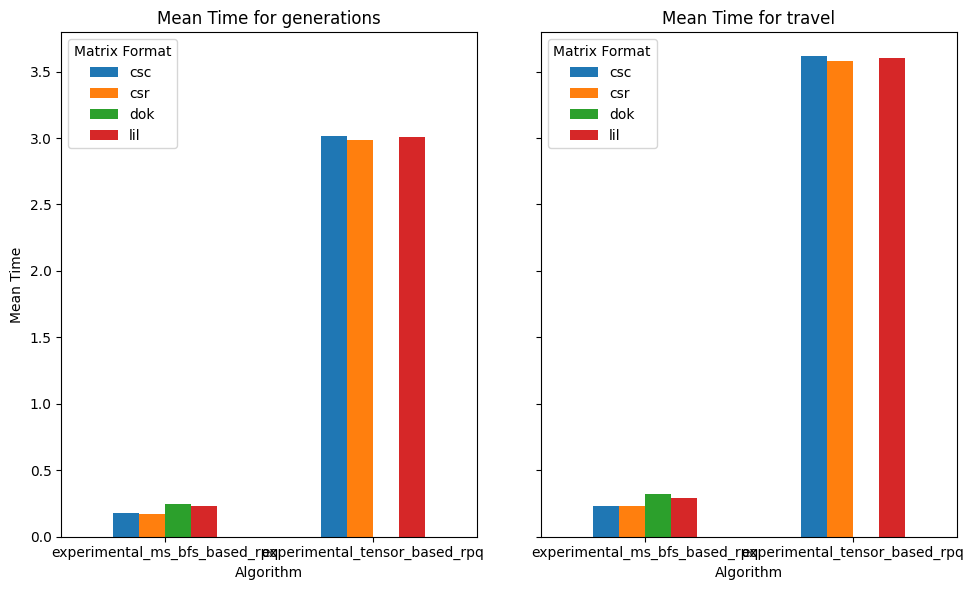

In [34]:
import matplotlib.pyplot as plt

# number of graphs
n_graphs = len(graph_names)

# Create subplots
fig, axes = plt.subplots(1, n_graphs, figsize=(5 * n_graphs, 6), sharey=True)

# Loop through each graph_name and create a bar plot
for ax, graph in zip(axes, graph_names):
    # Group by algorithm and matrix_format, calculating the mean time
    grouped = (
        df[df["graph_name"] == graph]
        .groupby(["algorithm", "matrix_format"])["time"]
        .mean()
        .unstack()
    )

    # Plotting
    grouped.plot(kind="bar", ax=ax)
    ax.set_title(f"Mean Time for {graph}")
    ax.set_xlabel("Algorithm")
    ax.set_ylabel("Mean Time")
    ax.set_xticks(range(len(grouped.index)))
    ax.set_xticklabels(grouped.index, rotation=0)
    ax.legend(title="Matrix Format")

# Adjust layout and show
plt.tight_layout()
plt.show()

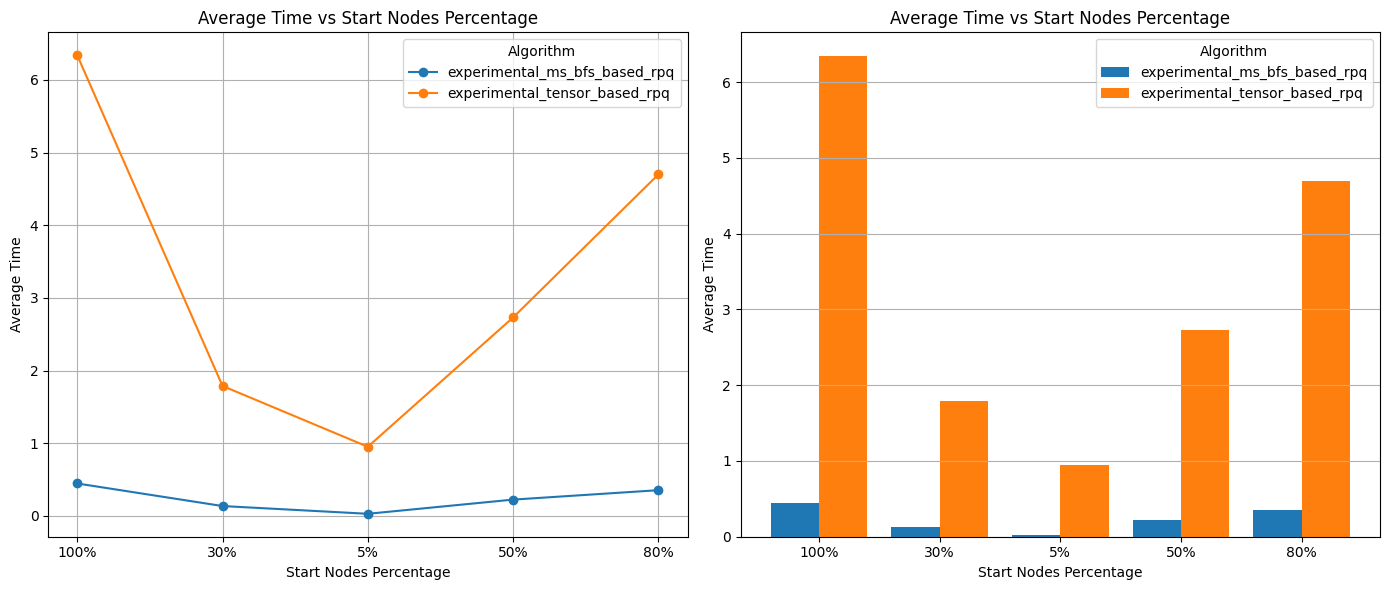

In [35]:
# Group by 'algorithm' and 'start_nodes_percentage', then calculate the average 'time'
avg_time = (
    df.groupby(["algorithm", "start_nodes_percentage"])["time"].mean().reset_index()
)

# Pivot the DataFrame to get algorithms as columns
pivot_df = avg_time.pivot(
    index="start_nodes_percentage", columns="algorithm", values="time"
)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plotting the line chart
for algorithm in pivot_df.columns:
    axes[0].plot(pivot_df.index, pivot_df[algorithm], marker="o", label=algorithm)

axes[0].set_title("Average Time vs Start Nodes Percentage")
axes[0].set_xlabel("Start Nodes Percentage")
axes[0].set_ylabel("Average Time")
axes[0].set_xticks(pivot_df.index)  # Ensure all x-ticks are shown
axes[0].legend(title="Algorithm")
axes[0].grid()

# Plotting the bar chart
pivot_df.plot(kind="bar", ax=axes[1], width=0.8)

axes[1].set_title("Average Time vs Start Nodes Percentage")
axes[1].set_xlabel("Start Nodes Percentage")
axes[1].set_ylabel("Average Time")
axes[1].set_xticks(range(len(pivot_df.index)))  # Ensure all x-ticks are shown
axes[1].set_xticklabels(pivot_df.index, rotation=0)
axes[1].legend(title="Algorithm")
axes[1].grid(axis="y")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Описание эксперимента